In [1]:
import pyNUISANCE as pn
import pyProSelecta as pps
import pyNuHepMC as nhm

In [2]:
evs = pn.EventSource("neutvect.t2kflux_numu_C_nofsi.root")
if not evs:
    print("Error: failed to open input file")

In [3]:
# the above line stops NEUT printouts
wf = pn.WeightCalcFactory()
t2krw = wf.make(evs, {"plugin_name":"T2KReWeight", "neut_cardname": "neut.t2kflux_numu_C_nofsi.card"})

Initializing with neut.t2kflux_numu_C_nofsi.card
 CRSPATH_ENV: /opt/neut/git_master/share/neut/crsdat
 Reading neut.t2kflux_numu_C_nofsi.card as card
 ======= CONFIGURATION FOR INTERACTIONS =======
 Reading neut.t2kflux_numu_C_nofsi.card as a card file
Reading bank: NEUT from card file: neut.t2kflux_numu_C_nofsi.card
Reading bank: NEUT from card file: neut.t2kflux_numu_C_nofsi.card
 Using Spectral Function for elastic events
 NECARD : INPUTTED PARAMETER 
 NECARD : CRSPATH= /opt/neut/git_master/share/neut/crsdat/
 NECARD : FERM   =            0
 NECARD : PAUL   =            1
 NECARD : PAUL2p2h =            0
 NECARD : NEFF   =            1
 NECARD : NUCDEXITE =            0
 NECARD : MODL   =            1
 NECARD : MODH   =            1
 NECARD : KINH   =            1
 NECARD : MODE   =            0
 NECARD : COHEPI =            2
 NECARD : DIFPI  =            0
 ********* CCQE SETTINGS ***************
 NECARD : MDLQE   =          402
 NECARD : MDLQEAF =            1
 NECARD : MDL2P2H 

In [4]:
pps.load_text("""
std::vector<double> enuq0q3Q2Lep_GeV(HepMC3::GenEvent const &ev){
  std::vector<double> rtn(4,0xdeadbeef);

  auto bpart = ps::sel::Beam(ev,14);
  if(!bpart) {
      return rtn;
  }
  rtn[0] = bpart->momentum().e() * 1E-3;
  auto lep = ps::sel::PrimaryCCLepForNu(ev, bpart);
  if(!lep) {
      return rtn;
  }
  rtn[1] = ps::proj::parts::q0(bpart,lep)*1E-3;
  rtn[2] = ps::proj::parts::q3(bpart,lep)*1E-3;
  rtn[3] = ps::proj::parts::Q2(bpart,lep)*1E-6;

  return rtn;
}

""")

True

In [5]:
import pprint

all_dials = []
for tgt in [ "C", ]:
    for nus in [ "nu", ]:
        for bi in range(3):
            all_dials.append("HFPW_toCRPAPWTwkDial_%s_%s_%s" % (tgt,nus,bi))
            all_dials.append("HFPW_toHFTwkDial_%s_%s_%s" % (tgt,nus,bi))

dial_tweaks = {}
for var in [1]:
    for di in all_dials:
        twk = {}
        for dj in all_dials:
            twk[dj] = var if di == dj else 0
        dial_tweaks["%s=%s" % (di,var)] = twk

dial_tweaks["CV"] = {"HFPW_toCRPAPWTwkDial_C_nu_0":0,
                     "HFPW_toCRPAPWTwkDial_C_nu_1":0,
                     "HFPW_toCRPAPWTwkDial_C_nu_2":0,
                     "HFPW_toHFTwkDial_C_nu_0":0,
                     "HFPW_toHFTwkDial_C_nu_1":0,
                     "HFPW_toHFTwkDial_C_nu_2":0}
# pprint.pp(dial_tweaks)
colnames = [ x for x in dial_tweaks.keys() ]
pprint.pp(colnames)

['HFPW_toCRPAPWTwkDial_C_nu_0=1',
 'HFPW_toHFTwkDial_C_nu_0=1',
 'HFPW_toCRPAPWTwkDial_C_nu_1=1',
 'HFPW_toHFTwkDial_C_nu_1=1',
 'HFPW_toCRPAPWTwkDial_C_nu_2=1',
 'HFPW_toHFTwkDial_C_nu_2=1',
 'CV']


In [6]:
def wghts(ev):
    resp = []
    for _,var in dial_tweaks.items():
        t2krw.set_parameters(var)
        resp.append(t2krw.calc_weight(ev))
    return resp

In [7]:
fg = pn.EventFrameGen(evs, 250000)\
  .filter(pps.select.process_id_exact(200)) \
  .add_columns(["enu","q0","q3","Q2Lep"], pps.project.get_vect("enuq0q3Q2Lep_GeV")) \
  .add_columns(colnames, wghts)

In [8]:
chunk = fg.firstArrow()

NIWGHadronTensor: reading hadron tensor table
table_file_name:  /root/software/NIWGReWeight/build/Linux/var/NIWG/hadronTensors/crpa_susav2/CRPA_1000060120_QE_Low.dat
Z:                6
A:                12
q0 bins:           170 between 0.0176657 and 0.0601657
q3 bins:           250 between 0.00899 and 2.00399
NIWGHadronTensor: reading hadron tensor table
table_file_name:  /root/software/NIWGReWeight/build/Linux/var/NIWG/hadronTensors/crpa_susav2/HF_1000060120_QE_Low.dat
Z:                6
A:                12
q0 bins:           170 between 0.0176657 and 0.0601657
q3 bins:           250 between 0.00899 and 2.00399
NIWGHadronTensor: reading hadron tensor table
table_file_name:  /root/software/NIWGReWeight/build/Linux/var/NIWG/hadronTensors/crpa_susav2/CRPA_1000060120_anu_QE_Low.dat
Z:                6
A:                12
q0 bins:           170 between 0.0176657 and 0.0601657
q3 bins:           250 between 0.00899 and 2.00399
NIWGHadronTensor: reading hadron tensor table
table_file_na

In [9]:
chunkp = chunk.to_pandas()

In [10]:
print(chunkp)

        event.number  weight.cv  process.id  fatx.estimate       enu  \
0                  3        1.0         200       0.127882  0.347806   
1                  4        1.0         200       0.127882  0.641626   
2                  8        1.0         200       0.127882  0.872321   
3                 13        1.0         200       0.127882  0.691914   
4                 14        1.0         200       0.127882  0.846386   
...              ...        ...         ...            ...       ...   
249995        612690        1.0         200       0.127882  0.278624   
249996        612693        1.0         200       0.127882  0.671384   
249997        612695        1.0         200       0.127882  0.867403   
249998        612697        1.0         200       0.127882  0.536075   
249999        612703        1.0         200       0.127882  0.595964   

              q0        q3     Q2Lep  HFPW_toCRPAPWTwkDial_C_nu_0=1  \
0       0.075782  0.285577  0.075811                       0.831

In [11]:
q0h = pn.HistFrame(pn.Binning.lin_space(0,0.7,50))

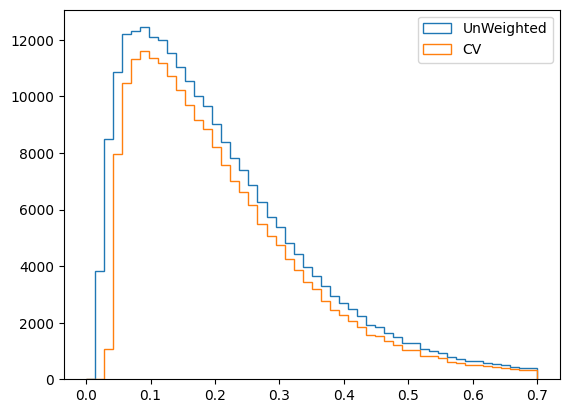

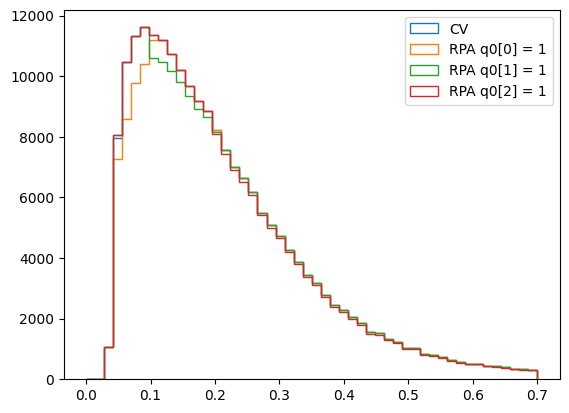

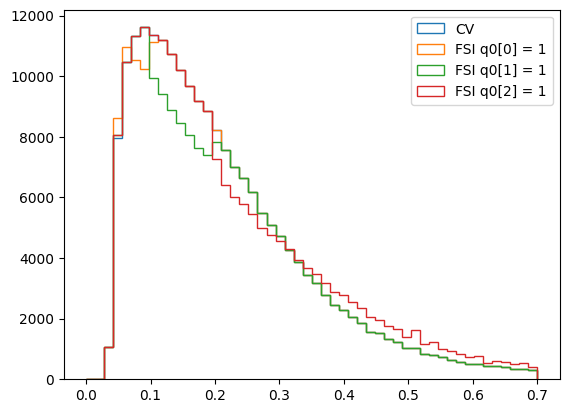

In [12]:
q0h = pn.HistFrame(pn.Binning.lin_space(0,0.7,50))
q0h.fill_weighted_columns_from_RecordBatch(chunk,["q0"],
                                          [ "CV",
                                            "HFPW_toCRPAPWTwkDial_C_nu_0=1",
                                            "HFPW_toCRPAPWTwkDial_C_nu_1=1",
                                            "HFPW_toCRPAPWTwkDial_C_nu_2=1",
                                            "HFPW_toHFTwkDial_C_nu_0=1",
                                            "HFPW_toHFTwkDial_C_nu_1=1",
                                            "HFPW_toHFTwkDial_C_nu_2=1"])

q0h.mpl().hist(histtype='step', label="UnWeighted")
q0h.mpl().hist(col="CV", histtype='step', label="CV")

pn.plt.legend()
pn.plt.show()

q0h.mpl().hist(col="CV", histtype='step', label="CV")
q0h.mpl().hist(col="HFPW_toCRPAPWTwkDial_C_nu_0=1", histtype='step', label="RPA q0[0] = 1")
q0h.mpl().hist(col="HFPW_toCRPAPWTwkDial_C_nu_1=1", histtype='step', label="RPA q0[1] = 1")
q0h.mpl().hist(col="HFPW_toCRPAPWTwkDial_C_nu_2=1", histtype='step', label="RPA q0[2] = 1")

pn.plt.legend()
pn.plt.show()

q0h.mpl().hist(col="CV", histtype='step', label="CV")
q0h.mpl().hist(col="HFPW_toHFTwkDial_C_nu_0=1", histtype='step', label="FSI q0[0] = 1")
q0h.mpl().hist(col="HFPW_toHFTwkDial_C_nu_1=1", histtype='step', label="FSI q0[1] = 1")
q0h.mpl().hist(col="HFPW_toHFTwkDial_C_nu_2=1", histtype='step', label="FSI q0[2] = 1")

pn.plt.legend()
pn.plt.show()

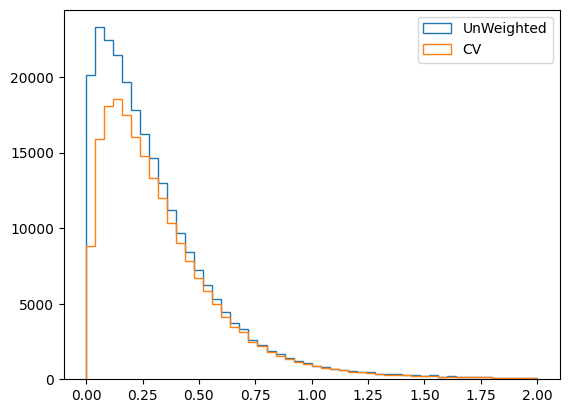

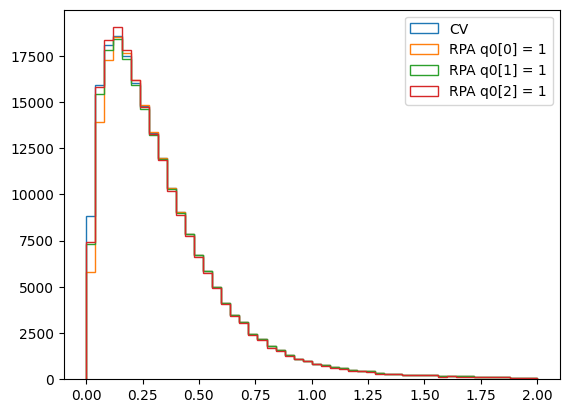

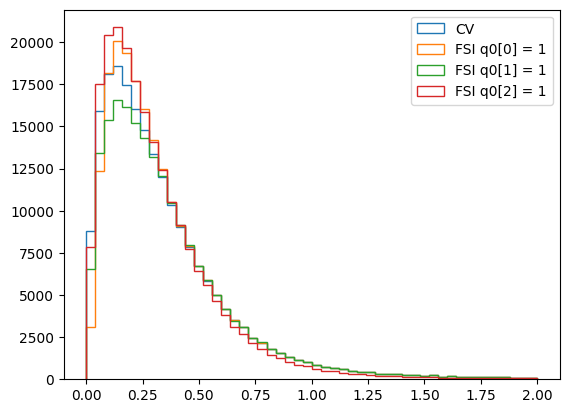

In [13]:
Q2Leph = pn.HistFrame(pn.Binning.lin_space(0,2,50))
Q2Leph.fill_weighted_columns_from_RecordBatch(chunk,["Q2Lep"],
                                          [ "CV",
                                            "HFPW_toCRPAPWTwkDial_C_nu_0=1",
                                            "HFPW_toCRPAPWTwkDial_C_nu_1=1",
                                            "HFPW_toCRPAPWTwkDial_C_nu_2=1",
                                            "HFPW_toHFTwkDial_C_nu_0=1",
                                            "HFPW_toHFTwkDial_C_nu_1=1",
                                            "HFPW_toHFTwkDial_C_nu_2=1"])

Q2Leph.mpl().hist(histtype='step', label="UnWeighted")
Q2Leph.mpl().hist(col="CV", histtype='step', label="CV")

pn.plt.legend()
pn.plt.show()

Q2Leph.mpl().hist(col="CV", histtype='step', label="CV")
Q2Leph.mpl().hist(col="HFPW_toCRPAPWTwkDial_C_nu_0=1", histtype='step', label="RPA q0[0] = 1")
Q2Leph.mpl().hist(col="HFPW_toCRPAPWTwkDial_C_nu_1=1", histtype='step', label="RPA q0[1] = 1")
Q2Leph.mpl().hist(col="HFPW_toCRPAPWTwkDial_C_nu_2=1", histtype='step', label="RPA q0[2] = 1")

pn.plt.legend()
pn.plt.show()

Q2Leph.mpl().hist(col="CV", histtype='step', label="CV")
Q2Leph.mpl().hist(col="HFPW_toHFTwkDial_C_nu_0=1", histtype='step', label="FSI q0[0] = 1")
Q2Leph.mpl().hist(col="HFPW_toHFTwkDial_C_nu_1=1", histtype='step', label="FSI q0[1] = 1")
Q2Leph.mpl().hist(col="HFPW_toHFTwkDial_C_nu_2=1", histtype='step', label="FSI q0[2] = 1")

pn.plt.legend()
pn.plt.show()